In [2]:
pip install lifelines



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

# Загрузка данных
exprs = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/exprs_PRJNA805525.csv', index_col=0)
ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/ann_PRJNA805525.csv')

# Фильтрация пациентов
filtered_ann = ann[
    (ann['BRAF_status_binary'] == 'Wt') & 
    (ann['KRAS_status'] == 'Wild Type')
].copy()

# Получаем отфильтрованные данные экспрессии
exprs_filtered = exprs.iloc[filtered_ann.index]  # Используем iloc для позиционного доступа

# Создаем финальный датафрейм
data = filtered_ann.copy()

# Добавляем нужные гены (убедитесь, что названия точно совпадают)
genes_to_extract = ['MET', 'VIM', 'CDH1']
for gene in genes_to_extract:
    if gene in exprs.columns:
        data[gene] = exprs_filtered[gene].values  # Используем .values для прямого присвоения
    else:
        print(f"Ген {gene} не найден в данных экспрессии")

# Проверка результата
print("\nПервые 5 строк после объединения:")
print(data[['BRAF_status_binary', 'KRAS_status'] + genes_to_extract].head())

# Проверка на NaN
print("\nКоличество NaN значений по генам:")
print(data[genes_to_extract].isna().sum())

# Сохранение
data.to_csv('filtered_data.csv', index=False)
print("\nДанные успешно сохранены в filtered_data.csv")


Первые 5 строк после объединения:
  BRAF_status_binary KRAS_status       MET        VIM      CDH1
0                 Wt   Wild Type  7.815669  10.111796  8.619343
1                 Wt   Wild Type  6.834084  11.160493  7.263821
2                 Wt   Wild Type  6.842642   9.345677  8.772760
3                 Wt   Wild Type  7.492584  10.217455  7.949827
5                 Wt   Wild Type  7.461016   9.834099  8.302990

Количество NaN значений по генам:
MET     0
VIM     0
CDH1    0
dtype: int64

Данные успешно сохранены в filtered_data_kp.csv


Медиана MET: 7.45
Распределение пациентов:
MET_group
High    39
Low     39
Name: count, dtype: int64


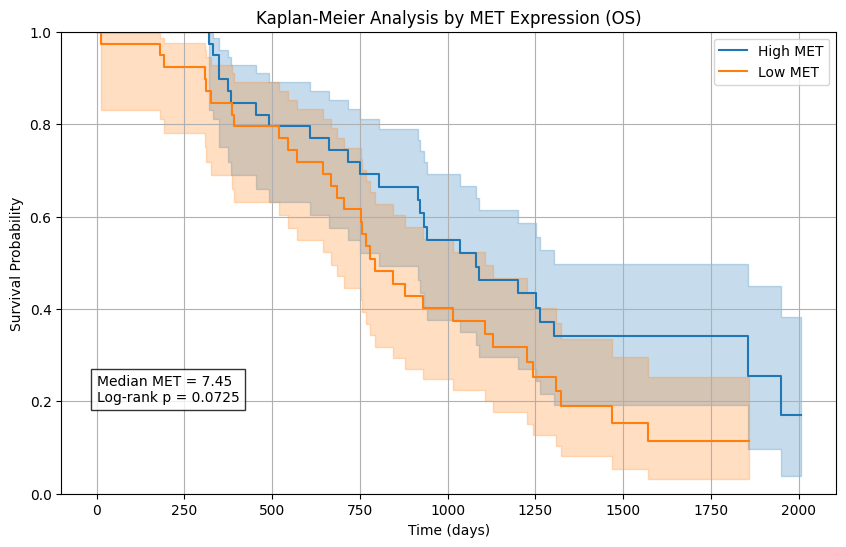


Данные с группами сохранены: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data.csv')

# Выбор конечной точки (можно изменить на PFS/PFS_FLAG)
time_col = 'OS'       # Общая выживаемость
event_col = 'OS_FLAG' # События для общей выживаемости

# 1. Разделение по уровню MET
median_met = data['MET'].median()
data['MET_group'] = ['High' if x > median_met else 'Low' for x in data['MET']]

print(f"Медиана MET: {median_met:.2f}")
print("Распределение пациентов:")
print(data['MET_group'].value_counts())

# 2. Kaplan-Meier анализ
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

# Для группы с высоким MET
high_met = data[data['MET_group'] == 'High']
kmf.fit(high_met[time_col], high_met[event_col], label='High MET')
ax = kmf.plot_survival_function(ci_show=True)

# Для группы с низким MET
low_met = data[data['MET_group'] == 'Low']
kmf.fit(low_met[time_col], low_met[event_col], label='Low MET')
kmf.plot_survival_function(ax=ax, ci_show=True)

# 3. Log-rank тест
results = logrank_test(
    high_met[time_col], 
    low_met[time_col],
    event_observed_A=high_met[event_col],
    event_observed_B=low_met[event_col]
)

# 4. Оформление графика
plt.title(f'Kaplan-Meier Analysis by MET Expression ({time_col})')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.ylim(0, 1)

# Добавление статистики
plt.text(0.6, 0.2, 
         f'Median MET = {median_met:.2f}\nLog-rank p = {results.p_value:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# 5. Сохранение данных с группами
output_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv'
data.to_csv(output_path, index=False)
print(f"\nДанные с группами сохранены: {output_path}")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data.csv')

# Разделение по медиане MET (50-й перцентиль)
median_met = data['MET'].median()
data['MET_high'] = (data['MET'] > median_met).astype(int)

# Инициализация и обучение модели
cph = CoxPHFitter()
cph.fit(data[['OS', 'OS_FLAG', 'MET_high']], 
        duration_col='OS', 
        event_col='OS_FLAG')

# Вывод результатов
print(cph.print_summary())


<lifelines.CoxPHFitter: fitted with 78 total observations, 20 right-censored observations>
             duration col = 'OS'
                event col = 'OS_FLAG'
      baseline estimation = breslow
   number of observations = 78
number of events observed = 58
   partial log-likelihood = -212.15
         time fit was run = 2025-05-12 07:30:51 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
MET_high  -0.48      0.62      0.27           -1.00            0.05                0.37                1.05

           cmp to     z    p  -log2(p)
covariate                             
MET_high     0.00 -1.78 0.08      3.73
---
Concordance = 0.56
Partial AIC = 426.30
log-likelihood ratio test = 3.19 on 1 df
-log2(p) of ll-ratio test = 3.76

None


17-й перцентиль MET: 6.68
83-й перцентиль MET: 7.98

Распределение пациентов:
MET_group
High (верхние 17%)    14
Low (нижние 17%)      14
Name: count, dtype: int64


/tmp/ipykernel_17995/3864036880.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_groups['is_high'] = (extreme_groups['MET_group'] == 'High (верхние 17%)').astype(int)


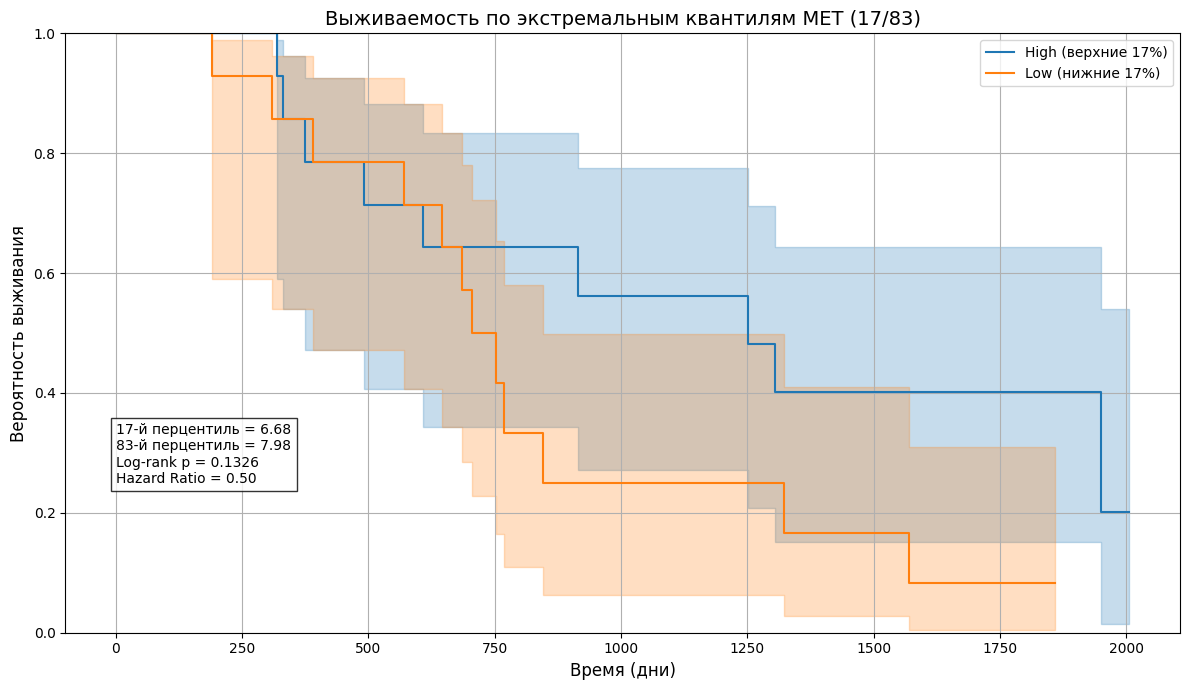

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data.csv')

# 1. Определение квантилей 17% и 83%
low_quantile = data['MET'].quantile(0.17)
high_quantile = data['MET'].quantile(0.83)

print(f"17-й перцентиль MET: {low_quantile:.2f}")
print(f"83-й перцентиль MET: {high_quantile:.2f}")

# 2. Разделение на 3 группы
data['MET_group'] = np.select(
    [
        data['MET'] <= low_quantile,
        data['MET'] >= high_quantile,
    ],
    [
        'Low (нижние 17%)',
        'High (верхние 17%)',
    ],
    default='Middle (центральные 66%)'
)

# 3. Анализ только крайних групп
extreme_groups = data[data['MET_group'].isin(['Low (нижние 17%)', 'High (верхние 17%)'])]

print("\nРаспределение пациентов:")
print(extreme_groups['MET_group'].value_counts())

# 4. Kaplan-Meier анализ
plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

# Визуализация
for name, group in extreme_groups.groupby('MET_group'):
    kmf.fit(group['OS'], group['OS_FLAG'], label=name)
    kmf.plot_survival_function(ci_show=True)

# 5. Статистический анализ
groups = extreme_groups['MET_group'].unique()
result = logrank_test(
    extreme_groups[extreme_groups['MET_group']==groups[0]]['OS'],
    extreme_groups[extreme_groups['MET_group']==groups[1]]['OS'],
    event_observed_A=extreme_groups[extreme_groups['MET_group']==groups[0]]['OS_FLAG'],
    event_observed_B=extreme_groups[extreme_groups['MET_group']==groups[1]]['OS_FLAG']
)

# Cox-регрессия
cph = CoxPHFitter()
extreme_groups['is_high'] = (extreme_groups['MET_group'] == 'High (верхние 17%)').astype(int)
cph.fit(extreme_groups[['OS', 'OS_FLAG', 'is_high']], duration_col='OS', event_col='OS_FLAG')

# 6. Визуализация результатов
plt.title('Выживаемость по экстремальным квантилям MET (17/83)', fontsize=14)
plt.xlabel('Время (дни)', fontsize=12)
plt.ylabel('Вероятность выживания', fontsize=12)
plt.grid(True)
plt.ylim(0, 1)

stats_text = f"""17-й перцентиль = {low_quantile:.2f}
83-й перцентиль = {high_quantile:.2f}
Log-rank p = {result.p_value:.4f}
Hazard Ratio = {np.exp(cph.params_['is_high']):.2f}"""
plt.text(0.6, 0.25, stats_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/MET_quantile_analysis.png', dpi=300)
plt.show()

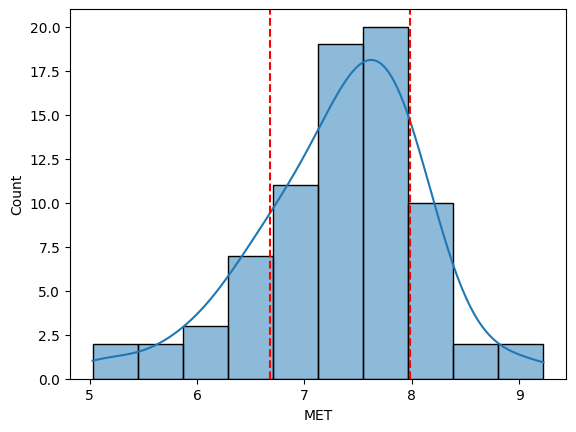

In [20]:
import seaborn as sns
sns.histplot(data['MET'], kde=True)
plt.axvline(low_quantile, color='red', linestyle='--')
plt.axvline(high_quantile, color='red', linestyle='--')

In [21]:
import pandas as pd
from lifelines import CoxPHFitter

# Загрузка данных (предполагаем, что файл содержит колонки: 'OS', 'OS_FLAG', 'MET')
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data.csv')

# Определение границ
low_q, high_q = data['MET'].quantile([0.17, 0.83])
data['MET_group'] = 'Middle'
data.loc[data['MET'] <= low_q, 'MET_group'] = 'Low'
data.loc[data['MET'] >= high_q, 'MET_group'] = 'High'

# Фильтрация только крайних групп
extreme_data = data[data['MET_group'].isin(['Low', 'High'])]

In [22]:
# Создание бинарной переменной (1 = High MET, 0 = Low MET)
extreme_data['MET_high'] = (extreme_data['MET_group'] == 'High').astype(int)

# Инициализация модели
cph = CoxPHFitter()

# Обучение модели
cph.fit(extreme_data[['OS', 'OS_FLAG', 'MET_high']], 
        duration_col='OS', 
        event_col='OS_FLAG')

# Вывод результатов
print(cph.print_summary())

/tmp/ipykernel_17995/1168346663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_data['MET_high'] = (extreme_data['MET_group'] == 'High').astype(int)


<lifelines.CoxPHFitter: fitted with 28 total observations, 7 right-censored observations>
             duration col = 'OS'
                event col = 'OS_FLAG'
      baseline estimation = breslow
   number of observations = 28
number of events observed = 21
   partial log-likelihood = -55.29
         time fit was run = 2025-05-08 19:29:26 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
MET_high  -0.68      0.50      0.46           -1.59            0.22                0.20                1.25

           cmp to     z    p  -log2(p)
covariate                             
MET_high     0.00 -1.48 0.14      2.84
---
Concordance = 0.57
Partial AIC = 112.58
log-likelihood ratio test = 2.24 on 1 df
-log2(p) of ll-ratio test = 2.89

None


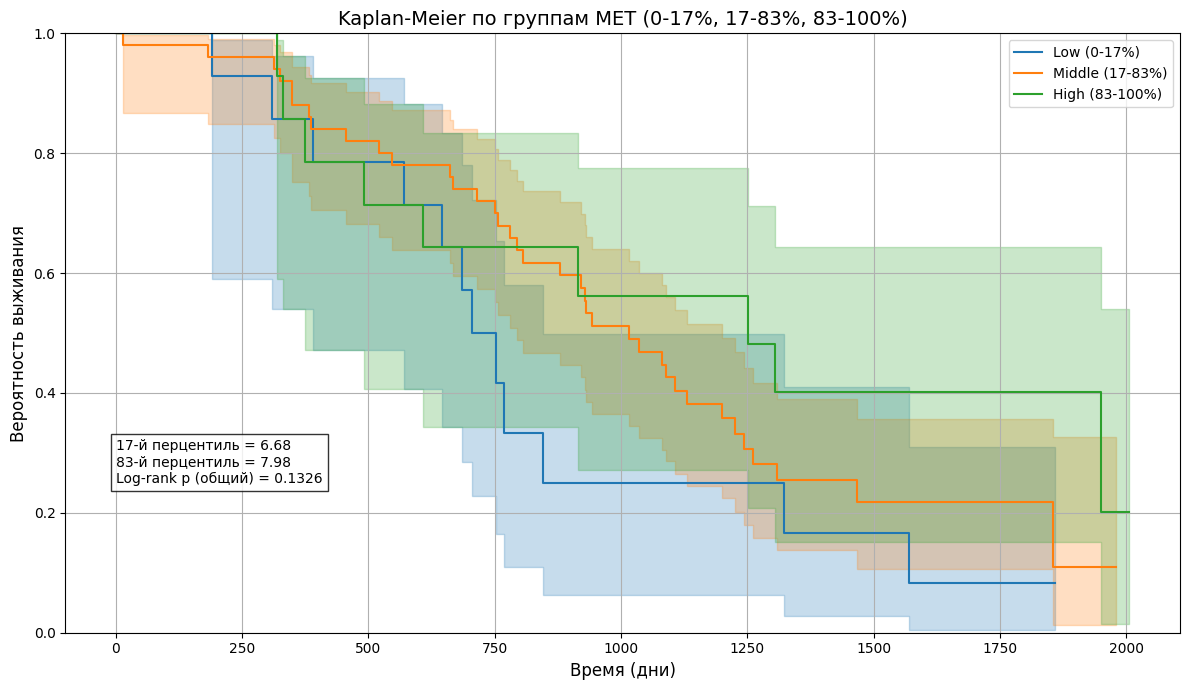


Результаты парных log-rank тестов:
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                test_statistic    p  -log2(p)
High (83-100%) Low (0-17%)                2.26 0.13      2.91
               Middle (17-83%)            0.86 0.35      1.50
Low (0-17%)    Middle (17-83%)            1.70 0.19      2.38


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import pairwise_logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data.csv')

# Определение квантилей 17% и 83%
low_q = data['MET'].quantile(0.17)
high_q = data['MET'].quantile(0.83)

# Разделение на 3 группы
data['MET_group'] = np.select(
    [
        data['MET'] <= low_q,
        (data['MET'] > low_q) & (data['MET'] < high_q),
        data['MET'] >= high_q
    ],
    [
        'Low (0-17%)',
        'Middle (17-83%)',
        'High (83-100%)'
    ]
)

# Kaplan-Meier анализ для всех 3 групп
plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

for group in ['Low (0-17%)', 'Middle (17-83%)', 'High (83-100%)']:
    subset = data[data['MET_group'] == group]
    kmf.fit(subset['OS'], subset['OS_FLAG'], label=group)
    kmf.plot_survival_function(ci_show=True)

# Парные log-rank тесты
results = pairwise_logrank_test(
    data['OS'],
    data['MET_group'],
    data['OS_FLAG']
)

# Оформление графика
plt.title('Kaplan-Meier по группам MET (0-17%, 17-83%, 83-100%)', fontsize=14)
plt.xlabel('Время (дни)', fontsize=12)
plt.ylabel('Вероятность выживания', fontsize=12)
plt.grid(True)
plt.ylim(0, 1)

# Добавление статистики
stats_text = f"""17-й перцентиль = {low_q:.2f}
83-й перцентиль = {high_q:.2f}
Log-rank p (общий) = {results.p_value.min():.4f}"""
plt.text(0.6, 0.25, stats_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('MET_3_groups_KM.png', dpi=300)
plt.show()

# Вывод результатов log-rank тестов
print("\nРезультаты парных log-rank тестов:")
print(results)

In [6]:
# Подготовка данных для Cox-регрессии
data['MET_group_encoded'] = data['MET_group'].map({
    'Low (0-17%)': 0,
    'Middle (17-83%)': 1,
    'High (83-100%)': 2
})

# Мультикатегориальная Cox-регрессия
cph = CoxPHFitter()
cph.fit(data[['OS', 'OS_FLAG', 'MET_group_encoded']], 
        duration_col='OS', 
        event_col='OS_FLAG')

# Вывод результатов
print("\nCox-регрессия (3 группы, Middle как референс):")
print(cph.print_summary())



Cox-регрессия (3 группы, Middle как референс):


<lifelines.CoxPHFitter: fitted with 78 total observations, 20 right-censored observations>
             duration col = 'OS'
                event col = 'OS_FLAG'
      baseline estimation = breslow
   number of observations = 78
number of events observed = 58
   partial log-likelihood = -212.29
         time fit was run = 2025-05-12 07:42:42 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
MET_group_encoded -0.39      0.68      0.23           -0.83            0.06                0.44                1.06

                   cmp to     z    p  -log2(p)
covariate                                     
MET_group_encoded    0.00 -1.71 0.09      3.52
---
Concordance = 0.55
Partial AIC = 426.57
log-likelihood ratio test = 2.93 on 1 df
-log2(p) of ll-ratio test = 3.52

None
